# OFA: Image Captioning with Transformers
In this notebook, we will show how to run the inference of OFA on image captioning with our support of OFA on Huggingface Transformers.

In brief, the whole process is simple. After building the environment and cloning the related codes and checkpoints, what you need to do is just to provide an image with some simple preprocessing, build the model and generator (either Fairseq generator that we provide or HF native generator), and obtain the result.


In [1]:
!pip install datasets
# !pip install transformers

In [2]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git

fatal: destination path 'OFA' already exists and is not an empty directory.


In [3]:
!pip install OFA/transformers/

Processing ./OFA/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916779 sha256=f47ed232566c3fa6a5466ad0c1d4d85b87fdb952332ac59ccee32ed5a140dbb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wupfgpix/wheels/0b/bc/ea/00b6b8998c20c4fe55affe6062a2cddda80308ef9bd5d5877c
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0.dev0
    Uninstalling transformers-4.18.0.dev0:
      Successfully uninstalled transformers-4.18.0.dev0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.18.0.dev0 which is incompatible.


In [4]:
!git lfs install
# !git clone https://huggingface.co/OFA-Sys/OFA-tiny
!git clone https://huggingface.co/OFA-Sys/OFA-tiny

Git LFS initialized.
fatal: destination path 'OFA-tiny' already exists and is not an empty directory.


In [5]:
from PIL import Image
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [6]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 256

In [7]:
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
ckpt_dir='./OFA-tiny'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

./OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [10]:
txt = " what does the image describe?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
!wget http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
!mv 3836680545_2ccb331621_z.jpg  test.jpg
img = Image.open('23.PNG')
patch_img = patch_resize_transform(img).unsqueeze(0)

--2024-12-14 04:22:51--  http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 3.163.96.74, 2600:9000:26c0:c600:0:5a51:64c9:c681, 2600:9000:26c0:ca00:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|3.163.96.74|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg [following]
--2024-12-14 04:22:51--  https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|3.163.96.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘3836680545_2ccb331621_z.jpg’

3836680545_2ccb3316     [ <=>                ] 131.20K  --.-KB/s    in 0.04s   

2024-12-14 04:22:51 (3.64 MB/s) - ‘3836680545_2ccb331621_z.jpg’ saved [134347]



In [11]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1440: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

## Choice of Generators
We find that using our provided generator can consistently achieve a better performance on the benchmark evaluation. Therefore, we first provide a demonstration of how to use this generator, and later the native one from Transformers.

In [12]:
generator = sequence_generator.SequenceGenerator(
    tokenizer=tokenizer,
    beam_size=5,
    max_len_b=16,
    min_len=0,
    no_repeat_ngram_size=3,
)

In [13]:
import torch
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}

In [14]:
gen_output = generator.generate([model], data)
gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

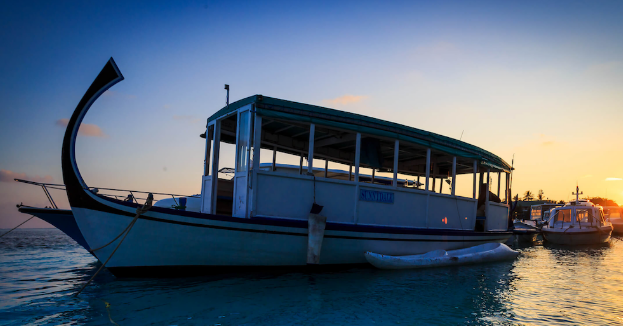

a blue boat in the water.


In [15]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [16]:
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

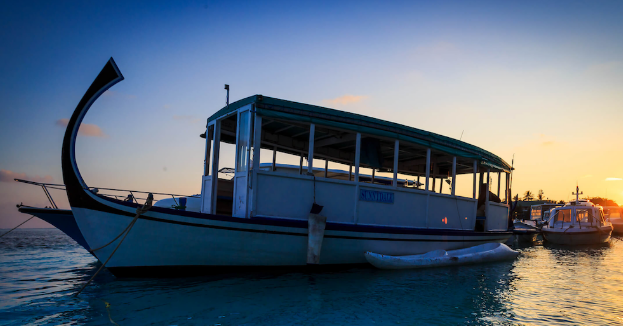

a blue boat in the water.


In [17]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [ ]:
!pip install fiftyone

In [ ]:
# import fiftyone as fo
# import fiftyone.zoo as foz

# #
# # Only the required images will be downloaded (if necessary).
# # By default, only detections are loaded
# #



In [ ]:
# import os
# import json
# import torch
# from transformers import OFATokenizer, OFAModel
# from datasets import load_dataset, DatasetDict
# from torch.utils.data import DataLoader
# from transformers import TrainingArguments, Trainer

# # Load OFA Tokenizer and Model
# def load_model_and_tokenizer(model_size="ofa-base"):
#     tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
#     model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
#     return model, tokenizer

# # Load dataset for a specific task
# def load_task_dataset(task_name):
#     if task_name == "image_captioning":
#         # dataset = load_dataset("ms_coco", split="train[:80%]")
#         dataset = load_dataset("shunk031/MSCOCO", year=2017, coco_task="captions", split="train",streaming=True)
#         # dataset = foz.load_zoo_dataset("coco-2017",split="train",
#         # max_samples=50,
#         #                                )
#         eval_dataset =load_dataset("shunk031/MSCOCO", year=2017, coco_task="captions", split="validation",streaming=True)
#         # eval_dataset = load_dataset("ms_coco", split="validation")
#     elif task_name == "vqa":
#         dataset = load_dataset("vqa", split="train[:80%]")
#         eval_dataset = load_dataset("vqa", split="validation")
#     else:
#         raise ValueError(f"Unsupported task: {task_name}")
#     return dataset, eval_dataset

# # Preprocess Dataset
# def preprocess_data(dataset, tokenizer, task_name):
#     def process(example):
#         if task_name == "image_captioning":
#             instruction = "What does the image describe?"
#             inputs = f"{instruction} {example['image']}"
#             labels = example['caption']
#         elif task_name == "vqa":
#             instruction = "Answer the question based on the image"
#             inputs = f"{instruction} {example['image']} {example['question']}"
#             labels = example['answer']
#         else:
#             raise ValueError("Task not supported.")
#         return {
#             "input_ids": tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids,
#             "labels": tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids,
#         }
#     return dataset.map(process, batched=True)

# # Evaluation Metrics
# def compute_metrics(predictions, labels, task_name):
#     if task_name == "image_captioning":
#         from nltk.translate.bleu_score import corpus_bleu
#         return {"BLEU": corpus_bleu(labels, predictions)}
#     elif task_name == "vqa":
#         correct = sum([1 for pred, label in zip(predictions, labels) if pred == label])
#         return {"Accuracy": correct / len(labels)}
#     else:
#         raise ValueError("Metrics not supported for this task.")

# # Main Training and Evaluation
# def main():
#     task_name = "image_captioning"  # Modify as needed
#     model_size = "ofa-tiny"         # Options: ofa-tiny, ofa-medium, etc.

#     # Load model and tokenizer
#     model, tokenizer = load_model_and_tokenizer(model_size)

#     # Load and preprocess dataset
#     train_dataset, eval_dataset = load_task_dataset(task_name)
#     train_dataset = preprocess_data(train_dataset, tokenizer, task_name)
#     eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)

#     # Set training arguments
#     training_args = TrainingArguments(
#         output_dir="./results",
#         evaluation_strategy="steps",
#         learning_rate=5e-5,
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         num_train_epochs=3,
#         weight_decay=0.01,
#         save_steps=5000,
#         save_total_limit=2,
#         load_best_model_at_end=True,
#         logging_dir="./logs",
#     )

#     # Define Trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=eval_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=lambda p: compute_metrics(p.predictions, p.label_ids, task_name),
#     )

#     # Train and evaluate
#     trainer.train()
#     metrics = trainer.evaluate()
#     print(f"Final Metrics: {metrics}")

# if __name__ == "__main__":
#     main()


In [ ]:
# import os
# import json
# import torch
# from transformers import OFATokenizer, OFAModel
# from datasets import load_dataset, DatasetDict,DownloadConfig
# from torch.utils.data import DataLoader

# # Load OFA Tokenizer and Model
# def load_model_and_tokenizer(model_size="ofa-base"):
#     tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
#     model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
#     return model, tokenizer

# # Load dataset for a specific task
# def load_task_dataset(task_name):
#     if task_name == "image_captioning":
#         eval_dataset = load_dataset("conceptual_captions", split="validation")
#         # eval_dataset =load_dataset("shunk031/MSCOCO", year=2017, coco_task="captions", split="validation",streaming=True)
#         # eval_dataset = load_dataset("shunk031/MSCOCO", year=2017, coco_task="captions", split="validation",
#         #                              cache_dir="./my_cache_dir", streaming=False,  # Disable streaming and enable caching
#         #                              data_dir="./mscoco_data/images",download_config=DownloadConfig(resume_download=True))
#         # eval_dataset = load_dataset("ms_coco", split="validation
#     elif task_name == "vqa":
#         eval_dataset = load_dataset("vqa", split="validation")
#     else:
#         raise ValueError(f"Unsupported task: {task_name}")
#     return eval_dataset

# # Preprocess Dataset
# def preprocess_data(dataset, tokenizer, task_name):
#     def process(example):
#         if task_name == "image_captioning":
#             instruction = "What does the image describe?"
#             image_path = example.get('image_path', example.get('image'))
#             inputs = f"{instruction} {image_path}"
#             labels = example['caption']

#             # inputs = f"{instruction} {example['image']}"
#             # labels = example['caption']
#         elif task_name == "vqa":
#             instruction = "Answer the question based on the image"
#             inputs = f"{instruction} {example['image']} {example['question']}"
#             labels = example['answer']
#         else:
#             raise ValueError("Task not supported.")
#         return {
#             "input_ids": tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids,
#             "labels": tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids,
#         }
#     return dataset.map(process, batched=True)

# # Evaluation Metrics
# def compute_metrics(predictions, labels, task_name):
#     if task_name == "image_captioning":
#         from nltk.translate.bleu_score import corpus_bleu
#         return {"BLEU": corpus_bleu(labels, predictions)}
#     elif task_name == "vqa":
#         correct = sum([1 for pred, label in zip(predictions, labels) if pred == label])
#         return {"Accuracy": correct / len(labels)}
#     else:
#         raise ValueError("Metrics not supported for this task.")

# # Main Evaluation
# def main():
#     task_name = "image_captioning"  # Modify as needed
#     model_size = "ofa-tiny"         # Options: ofa-tiny, ofa-medium, etc.

#     # Load model and tokenizer
#     model, tokenizer = load_model_and_tokenizer(model_size)
#     print("hello")

#     # Load and preprocess dataset
#     eval_dataset = load_task_dataset(task_name)
#     eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)

#     # Evaluate model
#     model.eval()
#     dataloader = DataLoader(eval_dataset, batch_size=8)

#     predictions, labels = [], []
#     with torch.no_grad():
#         for batch in dataloader:
#             outputs = model.generate(input_ids=batch["input_ids"].squeeze(1))
#             predictions.extend([tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
#             labels.extend([tokenizer.decode(l, skip_special_tokens=True) for l in batch["labels"].squeeze(1)])

#     metrics = compute_metrics(predictions, labels, task_name)
#     print(f"Evaluation Metrics: {metrics}")

# if __name__ == "__main__":
#     main()


In [ ]:
# import os
# import json
# import torch
# from transformers import OFATokenizer, OFAModel
# from datasets import load_dataset, DatasetDict
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from PIL import Image

# # Load OFA Tokenizer and Model
# def load_model_and_tokenizer(model_size="ofa-base"):
#     tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
#     model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
#     return model, tokenizer

# # Load dataset for a specific task
# def load_task_dataset(task_name):
#     if task_name == "vqa":
#         eval_dataset = load_dataset("textvqa", split="validation")
#     else:
#         raise ValueError(f"Unsupported task: {task_name}")
#     return eval_dataset

# # Image transformation for preprocessing
# def preprocess_image(image_path):
#     transform = transforms.Compose([
#         transforms.Resize((256, 256)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
#     image = Image.open(image_path).convert("RGB")
#     return transform(image).unsqueeze(0)

# # Preprocess Dataset
# def preprocess_data(dataset, tokenizer, task_name):
#     def process(example):
#         if task_name == "vqa":
#             instruction = "Answer the question based on the image."
#             image_tensor = preprocess_image(example['image'])
#             inputs = f"{instruction} {example['question']}"
#             labels = example['answer']
#         else:
#             raise ValueError("Task not supported.")

#         tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids
#         tokenized_labels = tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids

#         return {
#             "input_ids": tokenized_inputs,
#             "labels": tokenized_labels,
#             "image": image_tensor,
#         }

#     return dataset.map(process, batched=False)

# # Evaluation Metrics
# def compute_metrics(predictions, labels, task_name):
#     if task_name == "vqa":
#         correct = sum([1 for pred, label in zip(predictions, labels) if pred.strip().lower() == label.strip().lower()])
#         return {"Accuracy": correct / len(labels)}
#     else:
#         raise ValueError("Metrics not supported for this task.")

# # Main Evaluation
# def main():
#     task_name = "vqa"  # Modify as needed
#     model_size = "ofa-tiny"         # Options: ofa-tiny, ofa-medium, etc.

#     # Load model and tokenizer
#     model, tokenizer = load_model_and_tokenizer(model_size)

#     # Load and preprocess dataset
#     eval_dataset = load_task_dataset(task_name)
#     eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)

#     # Evaluate model
#     model.eval()
#     dataloader = DataLoader(eval_dataset, batch_size=8)

#     predictions, labels = [], []
#     with torch.no_grad():
#         for batch in dataloader:
#             outputs = model.generate(input_ids=batch["input_ids"].squeeze(1), pixel_values=batch["image"])
#             predictions.extend([tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
#             labels.extend([tokenizer.decode(l, skip_special_tokens=True) for l in batch["labels"].squeeze(1)])

#     metrics = compute_metrics(predictions, labels, task_name)
#     print(f"Evaluation Metrics: {metrics}")

# if __name__ == "__main__":
#     main()


In [ ]:
# import os
# import json
# import torch
# from transformers import OFATokenizer, OFAModel
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from PIL import Image
# from io import BytesIO
# import requests

# # Load OFA Tokenizer and Model
# def load_model_and_tokenizer(model_size="ofa-base"):
#     tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
#     model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
#     return model, tokenizer

# # Load dataset for a specific task
# def load_task_dataset(task_name):
#     if task_name == "vqa":
#         eval_dataset = load_dataset("textvqa", split="validation")
#     else:
#         raise ValueError(f"Unsupported task: {task_name}")
#     return eval_dataset

# # Image transformation for preprocessing
# def preprocess_image(image_url):
#     transform = transforms.Compose([
#         transforms.Resize((256, 256)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
#     response = requests.get(image_url)
#     if response.status_code == 200:
#         image = Image.open(BytesIO(response.content)).convert("RGB")
#         return transform(image).unsqueeze(0)
#     else:
#         raise ValueError("Could not fetch the image from the provided URL.")

# # Preprocess Dataset
# def preprocess_data(dataset, tokenizer, task_name):
#     def process(example):
#         if task_name == "vqa":
#             instruction = "Answer the question based on the image."
#             image_tensor = preprocess_image(example['image'])
#             inputs = f"{instruction} {example['question']}"
#             labels = example['answer']
#         else:
#             raise ValueError("Task not supported.")

#         tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids
#         tokenized_labels = tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids

#         return {
#             "input_ids": tokenized_inputs,
#             "labels": tokenized_labels,
#             "image": image_tensor,
#         }

#     return dataset.map(process, batched=False)

# # Evaluation Metrics
# def compute_metrics(predictions, labels, task_name):
#     if task_name == "vqa":
#         correct = sum([1 for pred, label in zip(predictions, labels) if pred.strip().lower() == label.strip().lower()])
#         return {"Accuracy": correct / len(labels)}
#     else:
#         raise ValueError("Metrics not supported for this task.")

# # Main Evaluation
# def main():
#     task_name = "vqa"  # Modify as needed
#     model_size = "ofa-base"         # Options: ofa-tiny, ofa-medium, etc.

#     # Load model and tokenizer
#     model, tokenizer = load_model_and_tokenizer(model_size)

#     # Load and preprocess dataset
#     eval_dataset = load_task_dataset(task_name)
#     eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)

#     # Evaluate model
#     model.eval()
#     dataloader = DataLoader(eval_dataset, batch_size=8)

#     predictions, labels = [], []
#     with torch.no_grad():
#         for batch in dataloader:
#             outputs = model.generate(input_ids=batch["input_ids"].squeeze(1), pixel_values=batch["image"])
#             predictions.extend([tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
#             labels.extend([tokenizer.decode(l, skip_special_tokens=True) for l in batch["labels"].squeeze(1)])

#     metrics = compute_metrics(predictions, labels, task_name)
#     print(f"Evaluation Metrics: {metrics}")

# if __name__ == "__main__":
#     main()


In [ ]:
# import os
# import json
# import torch
# from transformers import OFATokenizer, OFAModel
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from PIL import Image

# # Load OFA Tokenizer and Model
# def load_model_and_tokenizer(model_size="ofa-base"):
#     tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
#     model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
#     return model, tokenizer

# # Load dataset for a specific task
# def load_task_dataset(task_name):
#     if task_name == "vqa":
#         eval_dataset = load_dataset("textvqa", split="validation")
#     else:
#         raise ValueError(f"Unsupported task: {task_name}")
#     return eval_dataset

# # Image transformation for preprocessing
# def preprocess_image(image):
#     transform = transforms.Compose([
#         transforms.Resize((256, 256)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
#     if isinstance(image, str):  # If it's a file path
#         image = Image.open(image).convert("RGB")
#     return transform(image).unsqueeze(0)

# # Preprocess Dataset
# def preprocess_data(dataset, tokenizer, task_name):
#     def process(example):
#         if task_name == "vqa":
#             instruction = "Answer the question based on the image."
#             image_tensor = preprocess_image(example['image'])
#             inputs = f"{instruction} {example['question']}"
#             labels = example['answer']
#         else:
#             raise ValueError("Task not supported.")

#         tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids
#         tokenized_labels = tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids

#         return {
#             "input_ids": tokenized_inputs,
#             "labels": tokenized_labels,
#             "image": image_tensor,
#         }

#     return dataset.map(process, batched=False)

# # Evaluation Metrics
# def compute_metrics(predictions, labels, task_name):
#     if task_name == "vqa":
#         correct = sum([1 for pred, label in zip(predictions, labels) if pred.strip().lower() == label.strip().lower()])
#         return {"Accuracy": correct / len(labels)}
#     else:
#         raise ValueError("Metrics not supported for this task.")

# # Main Evaluation
# def main():
#     task_name = "vqa"  # Modify as needed
#     model_size = "ofa-base"         # Options: ofa-tiny, ofa-medium, etc.

#     # Load model and tokenizer
#     model, tokenizer = load_model_and_tokenizer(model_size)

#     # Load and preprocess dataset
#     eval_dataset = load_task_dataset(task_name)
#     eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)

#     # Evaluate model
#     model.eval()
#     dataloader = DataLoader(eval_dataset, batch_size=8)

#     predictions, labels = [], []
#     with torch.no_grad():
#         for batch in dataloader:
#             outputs = model.generate(input_ids=batch["input_ids"].squeeze(1), pixel_values=batch["image"])
#             predictions.extend([tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
#             labels.extend([tokenizer.decode(l, skip_special_tokens=True) for l in batch["labels"].squeeze(1)])

#     metrics = compute_metrics(predictions, labels, task_name)
#     print(f"Evaluation Metrics: {metrics}")

# if __name__ == "__main__":
#     main()


In [19]:
import os
import json
import torch
from transformers import OFATokenizer, OFAModel
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Load OFA Tokenizer and Model
def load_model_and_tokenizer(model_size="ofa-base"):
    # Load the tokenizer and model for the specified size (e.g., ofa-base, ofa-tiny)
    tokenizer = OFATokenizer.from_pretrained(f"OFA-Sys/{model_size}")
    model = OFAModel.from_pretrained(f"OFA-Sys/{model_size}")
    return model, tokenizer

# Load dataset for the VQAv2 task
def load_task_dataset(task_name):
    if task_name == "vqa":
        # Load the VQAv2 dataset's validation split
        eval_dataset = load_dataset("lmms-lab/VQAv2", split="validation")
    else:
        # Raise an error if the task is not supported
        raise ValueError(f"Unsupported task: {task_name}")
    return eval_dataset

# Image transformation for preprocessing
def preprocess_image(image):
    # Define the transformation pipeline for images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
        transforms.ToTensor(),  # Convert image to a tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize pixel values
    ])
    if isinstance(image, str):  # Check if the image is a file path
        image = Image.open(image).convert("RGB")  # Open and convert image to RGB
    return transform(image).unsqueeze(0)  # Add a batch dimension

# Preprocess Dataset
def preprocess_data(dataset, tokenizer, task_name):
    # Preprocess the dataset by tokenizing inputs and transforming images
    def process(example):
        if task_name == "vqa":
            # Add an instruction to the input for VQA
            instruction = "Answer the question based on the image."
            # Preprocess the image
            image_tensor = preprocess_image(example['image'])
            # Combine the instruction and question
            inputs = f"{instruction} {example['question']}"
            # Get the answer labels
            labels = example['answers'][0]  # Use the first answer as the label
        else:
            # Raise an error if the task is not supported
            raise ValueError("Task not supported.")

        # Tokenize the inputs and labels
        tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).input_ids
        tokenized_labels = tokenizer(labels, return_tensors="pt", padding=True, truncation=True).input_ids

        return {
            "input_ids": tokenized_inputs,  # Tokenized input IDs
            "labels": tokenized_labels,    # Tokenized label IDs
            "image": image_tensor,         # Preprocessed image tensor
        }

    # Apply the preprocessing function to the dataset
    return dataset.map(process, batched=False)

# Evaluation Metrics
def compute_metrics(predictions, labels, task_name):
    # Compute evaluation metrics based on the task
    if task_name == "vqa":
        # Calculate accuracy by comparing predictions to labels
        correct = sum([1 for pred, label in zip(predictions, labels) if pred.strip().lower() == label.strip().lower()])
        return {"Accuracy": correct / len(labels)}
    else:
        # Raise an error if metrics for the task are not supported
        raise ValueError("Metrics not supported for this task.")

# Main Evaluation
def main():
    # Specify the task and model size
    task_name = "vqa"  # Task: Visual Question Answering
    model_size = "ofa-base"         # Model size: Options include ofa-tiny, ofa-medium, etc.

    # Load model and tokenizer
    model, tokenizer = load_model_and_tokenizer(model_size)

    # Load and preprocess dataset
    eval_dataset = load_task_dataset(task_name)  # Load the dataset
    eval_dataset = preprocess_data(eval_dataset, tokenizer, task_name)  # Preprocess the dataset

    # Set the model to evaluation mode
    model.eval()
    # Create a DataLoader for batch processing
    dataloader = DataLoader(eval_dataset, batch_size=8)

    # Initialize lists to store predictions and labels
    predictions, labels = [], []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            # Generate predictions using the model
            outputs = model.generate(input_ids=batch["input_ids"].squeeze(1), pixel_values=batch["image"])
            # Decode the predictions and labels
            predictions.extend([tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
            labels.extend([tokenizer.decode(l, skip_special_tokens=True) for l in batch["labels"].squeeze(1)])

    # Compute evaluation metrics
    metrics = compute_metrics(predictions, labels, task_name)
    # Print the evaluation metrics
    print(f"Evaluation Metrics: {metrics}")

if __name__ == "__main__":
    main()


OFA-Sys/ofa-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


README.md:   0%|          | 0.00/962 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/143 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/143 [00:00<?, ?it/s]

validation-00000-of-00068.parquet:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

validation-00001-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00002-of-00068.parquet:   0%|          | 0.00/98.5M [00:00<?, ?B/s]

validation-00003-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00004-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00005-of-00068.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

validation-00006-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00007-of-00068.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

validation-00008-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00009-of-00068.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

validation-00010-of-00068.parquet:   0%|          | 0.00/109M [00:00<?, ?B/s]

validation-00011-of-00068.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

validation-00012-of-00068.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

validation-00013-of-00068.parquet:   0%|          | 0.00/97.2M [00:00<?, ?B/s]

validation-00014-of-00068.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

validation-00015-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00016-of-00068.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

validation-00017-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00018-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00019-of-00068.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

validation-00020-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00021-of-00068.parquet:   0%|          | 0.00/99.3M [00:00<?, ?B/s]

validation-00022-of-00068.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

validation-00023-of-00068.parquet:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

validation-00024-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00025-of-00068.parquet:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

validation-00026-of-00068.parquet:   0%|          | 0.00/98.5M [00:00<?, ?B/s]

validation-00027-of-00068.parquet:   0%|          | 0.00/111M [00:00<?, ?B/s]

validation-00028-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00029-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00030-of-00068.parquet:   0%|          | 0.00/96.2M [00:00<?, ?B/s]

validation-00031-of-00068.parquet:   0%|          | 0.00/109M [00:00<?, ?B/s]

validation-00032-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00033-of-00068.parquet:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

validation-00034-of-00068.parquet:   0%|          | 0.00/95.9M [00:00<?, ?B/s]

validation-00035-of-00068.parquet:   0%|          | 0.00/109M [00:00<?, ?B/s]

validation-00036-of-00068.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

validation-00037-of-00068.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

validation-00038-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00039-of-00068.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

validation-00040-of-00068.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

validation-00041-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00042-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00043-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00044-of-00068.parquet:   0%|          | 0.00/92.7M [00:00<?, ?B/s]

validation-00045-of-00068.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

validation-00046-of-00068.parquet:   0%|          | 0.00/97.9M [00:00<?, ?B/s]

validation-00047-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00048-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00049-of-00068.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

validation-00050-of-00068.parquet:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

validation-00051-of-00068.parquet:   0%|          | 0.00/93.6M [00:00<?, ?B/s]

validation-00052-of-00068.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

validation-00053-of-00068.parquet:   0%|          | 0.00/97.4M [00:00<?, ?B/s]

validation-00054-of-00068.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

validation-00055-of-00068.parquet:   0%|          | 0.00/93.2M [00:00<?, ?B/s]

validation-00056-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00057-of-00068.parquet:   0%|          | 0.00/110M [00:00<?, ?B/s]

validation-00058-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00059-of-00068.parquet:   0%|          | 0.00/95.9M [00:00<?, ?B/s]

validation-00060-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00061-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00062-of-00068.parquet:   0%|          | 0.00/99.5M [00:00<?, ?B/s]

validation-00063-of-00068.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

validation-00064-of-00068.parquet:   0%|          | 0.00/99.4M [00:00<?, ?B/s]

validation-00065-of-00068.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

validation-00066-of-00068.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

validation-00067-of-00068.parquet:   0%|          | 0.00/99.1M [00:00<?, ?B/s]

testdev-00000-of-00036.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

testdev-00001-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00002-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00003-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00004-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00005-of-00036.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

testdev-00006-of-00036.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

testdev-00007-of-00036.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

testdev-00008-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00009-of-00036.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

testdev-00010-of-00036.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

testdev-00011-of-00036.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

testdev-00012-of-00036.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

testdev-00013-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00014-of-00036.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

testdev-00015-of-00036.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

testdev-00016-of-00036.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

testdev-00017-of-00036.parquet:   0%|          | 0.00/168M [00:00<?, ?B/s]

testdev-00018-of-00036.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

testdev-00019-of-00036.parquet:   0%|          | 0.00/168M [00:00<?, ?B/s]

testdev-00020-of-00036.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

testdev-00021-of-00036.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

testdev-00022-of-00036.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

testdev-00023-of-00036.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

testdev-00024-of-00036.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

testdev-00025-of-00036.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

testdev-00026-of-00036.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

testdev-00027-of-00036.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

testdev-00028-of-00036.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

testdev-00029-of-00036.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

testdev-00030-of-00036.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

testdev-00031-of-00036.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

testdev-00032-of-00036.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

testdev-00033-of-00036.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

testdev-00034-of-00036.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

testdev-00035-of-00036.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

test-00000-of-00143.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

test-00001-of-00143.parquet:   0%|          | 0.00/94.6M [00:00<?, ?B/s]

test-00002-of-00143.parquet:   0%|          | 0.00/98.9M [00:00<?, ?B/s]

test-00003-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00004-of-00143.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

test-00005-of-00143.parquet:   0%|          | 0.00/89.2M [00:00<?, ?B/s]

test-00006-of-00143.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

test-00007-of-00143.parquet:   0%|          | 0.00/97.7M [00:00<?, ?B/s]

test-00008-of-00143.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

test-00009-of-00143.parquet:   0%|          | 0.00/93.8M [00:00<?, ?B/s]

test-00010-of-00143.parquet:   0%|          | 0.00/95.8M [00:00<?, ?B/s]

test-00011-of-00143.parquet:   0%|          | 0.00/88.0M [00:00<?, ?B/s]

test-00012-of-00143.parquet:   0%|          | 0.00/92.2M [00:00<?, ?B/s]

test-00013-of-00143.parquet:   0%|          | 0.00/97.9M [00:00<?, ?B/s]

test-00014-of-00143.parquet:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

test-00015-of-00143.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

test-00016-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00017-of-00143.parquet:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

test-00018-of-00143.parquet:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

test-00019-of-00143.parquet:   0%|          | 0.00/92.0M [00:00<?, ?B/s]

test-00020-of-00143.parquet:   0%|          | 0.00/91.0M [00:00<?, ?B/s]

test-00021-of-00143.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

test-00022-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00023-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00024-of-00143.parquet:   0%|          | 0.00/95.0M [00:00<?, ?B/s]

test-00025-of-00143.parquet:   0%|          | 0.00/93.6M [00:00<?, ?B/s]

test-00026-of-00143.parquet:   0%|          | 0.00/89.0M [00:00<?, ?B/s]

test-00027-of-00143.parquet:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

test-00028-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00029-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00030-of-00143.parquet:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

test-00031-of-00143.parquet:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

test-00032-of-00143.parquet:   0%|          | 0.00/99.4M [00:00<?, ?B/s]

test-00033-of-00143.parquet:   0%|          | 0.00/99.5M [00:00<?, ?B/s]

test-00034-of-00143.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00035-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00036-of-00143.parquet:   0%|          | 0.00/92.6M [00:00<?, ?B/s]

test-00037-of-00143.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

test-00038-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00039-of-00143.parquet:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

test-00040-of-00143.parquet:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

test-00041-of-00143.parquet:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

test-00042-of-00143.parquet:   0%|          | 0.00/97.7M [00:00<?, ?B/s]

test-00043-of-00143.parquet:   0%|          | 0.00/97.4M [00:00<?, ?B/s]

test-00044-of-00143.parquet:   0%|          | 0.00/97.7M [00:00<?, ?B/s]

test-00045-of-00143.parquet:   0%|          | 0.00/88.1M [00:00<?, ?B/s]

test-00046-of-00143.parquet:   0%|          | 0.00/86.3M [00:00<?, ?B/s]

test-00047-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00048-of-00143.parquet:   0%|          | 0.00/97.2M [00:00<?, ?B/s]

test-00049-of-00143.parquet:   0%|          | 0.00/96.1M [00:00<?, ?B/s]

test-00050-of-00143.parquet:   0%|          | 0.00/86.9M [00:00<?, ?B/s]

test-00051-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00052-of-00143.parquet:   0%|          | 0.00/92.2M [00:00<?, ?B/s]

test-00053-of-00143.parquet:   0%|          | 0.00/96.6M [00:00<?, ?B/s]

test-00054-of-00143.parquet:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

test-00055-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00056-of-00143.parquet:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

test-00057-of-00143.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

test-00058-of-00143.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

test-00059-of-00143.parquet:   0%|          | 0.00/104M [00:00<?, ?B/s]

test-00060-of-00143.parquet:   0%|          | 0.00/93.3M [00:00<?, ?B/s]

test-00061-of-00143.parquet:   0%|          | 0.00/93.0M [00:00<?, ?B/s]

test-00062-of-00143.parquet:   0%|          | 0.00/99.9M [00:00<?, ?B/s]

test-00063-of-00143.parquet:   0%|          | 0.00/92.9M [00:00<?, ?B/s]

test-00064-of-00143.parquet:   0%|          | 0.00/91.9M [00:00<?, ?B/s]

test-00065-of-00143.parquet:   0%|          | 0.00/95.0M [00:00<?, ?B/s]

test-00066-of-00143.parquet:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

test-00067-of-00143.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

test-00068-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00069-of-00143.parquet:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

test-00070-of-00143.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

test-00071-of-00143.parquet:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

test-00072-of-00143.parquet:   0%|          | 0.00/93.5M [00:00<?, ?B/s]

test-00073-of-00143.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00074-of-00143.parquet:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

test-00075-of-00143.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

test-00076-of-00143.parquet:   0%|          | 0.00/97.1M [00:00<?, ?B/s]

test-00077-of-00143.parquet:   0%|          | 0.00/94.9M [00:00<?, ?B/s]

test-00078-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00079-of-00143.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

test-00080-of-00143.parquet:   0%|          | 0.00/96.9M [00:00<?, ?B/s]

test-00081-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00082-of-00143.parquet:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

test-00083-of-00143.parquet:   0%|          | 0.00/97.0M [00:00<?, ?B/s]

test-00084-of-00143.parquet:   0%|          | 0.00/95.7M [00:00<?, ?B/s]

test-00085-of-00143.parquet:   0%|          | 0.00/98.9M [00:00<?, ?B/s]

test-00086-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00087-of-00143.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

test-00088-of-00143.parquet:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

test-00089-of-00143.parquet:   0%|          | 0.00/98.5M [00:00<?, ?B/s]

test-00090-of-00143.parquet:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

test-00091-of-00143.parquet:   0%|          | 0.00/96.9M [00:00<?, ?B/s]

test-00092-of-00143.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

test-00093-of-00143.parquet:   0%|          | 0.00/96.1M [00:00<?, ?B/s]

test-00094-of-00143.parquet:   0%|          | 0.00/96.1M [00:00<?, ?B/s]

test-00095-of-00143.parquet:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

test-00096-of-00143.parquet:   0%|          | 0.00/93.5M [00:00<?, ?B/s]

test-00097-of-00143.parquet:   0%|          | 0.00/94.7M [00:00<?, ?B/s]

test-00098-of-00143.parquet:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

test-00099-of-00143.parquet:   0%|          | 0.00/91.1M [00:00<?, ?B/s]

test-00100-of-00143.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

test-00101-of-00143.parquet:   0%|          | 0.00/99.3M [00:00<?, ?B/s]

test-00102-of-00143.parquet:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

test-00103-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00104-of-00143.parquet:   0%|          | 0.00/95.6M [00:00<?, ?B/s]

test-00105-of-00143.parquet:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

test-00106-of-00143.parquet:   0%|          | 0.00/96.1M [00:00<?, ?B/s]

test-00107-of-00143.parquet:   0%|          | 0.00/94.5M [00:00<?, ?B/s]

test-00108-of-00143.parquet:   0%|          | 0.00/95.7M [00:00<?, ?B/s]

test-00109-of-00143.parquet:   0%|          | 0.00/89.3M [00:00<?, ?B/s]

test-00110-of-00143.parquet:   0%|          | 0.00/94.5M [00:00<?, ?B/s]

test-00111-of-00143.parquet:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

test-00112-of-00143.parquet:   0%|          | 0.00/96.3M [00:00<?, ?B/s]

test-00113-of-00143.parquet:   0%|          | 0.00/93.7M [00:00<?, ?B/s]

test-00114-of-00143.parquet:   0%|          | 0.00/93.2M [00:00<?, ?B/s]

test-00115-of-00143.parquet:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

test-00116-of-00143.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00117-of-00143.parquet:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

test-00118-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00119-of-00143.parquet:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

test-00120-of-00143.parquet:   0%|          | 0.00/98.6M [00:00<?, ?B/s]

test-00121-of-00143.parquet:   0%|          | 0.00/91.1M [00:00<?, ?B/s]

test-00122-of-00143.parquet:   0%|          | 0.00/88.1M [00:00<?, ?B/s]

test-00123-of-00143.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

test-00124-of-00143.parquet:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

test-00125-of-00143.parquet:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

test-00126-of-00143.parquet:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

test-00127-of-00143.parquet:   0%|          | 0.00/99.4M [00:00<?, ?B/s]

test-00128-of-00143.parquet:   0%|          | 0.00/93.9M [00:00<?, ?B/s]

test-00129-of-00143.parquet:   0%|          | 0.00/97.2M [00:00<?, ?B/s]

test-00130-of-00143.parquet:   0%|          | 0.00/96.2M [00:00<?, ?B/s]

test-00131-of-00143.parquet:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

test-00132-of-00143.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

test-00133-of-00143.parquet:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

test-00134-of-00143.parquet:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

test-00135-of-00143.parquet:   0%|          | 0.00/97.5M [00:00<?, ?B/s]

test-00136-of-00143.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00137-of-00143.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

test-00138-of-00143.parquet:   0%|          | 0.00/95.0M [00:00<?, ?B/s]

test-00139-of-00143.parquet:   0%|          | 0.00/89.0M [00:00<?, ?B/s]

test-00140-of-00143.parquet:   0%|          | 0.00/97.4M [00:00<?, ?B/s]

test-00141-of-00143.parquet:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

test-00142-of-00143.parquet:   0%|          | 0.00/91.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/214354 [00:00<?, ? examples/s]

KeyboardInterrupt: 